<a href="https://colab.research.google.com/github/timetime0628/.txt-geotiff-/blob/main/txt%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%82%92geotiff%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AB%E6%9B%B8%E3%81%8D%E6%8F%9B%E3%81%88%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import glob
from osgeo import gdal, gdalconst, gdal_array, osr

In [ ]:
# Google Colaboratoryとgoogle Driveを使う場合
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/My Drive/災害前高知DEM/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


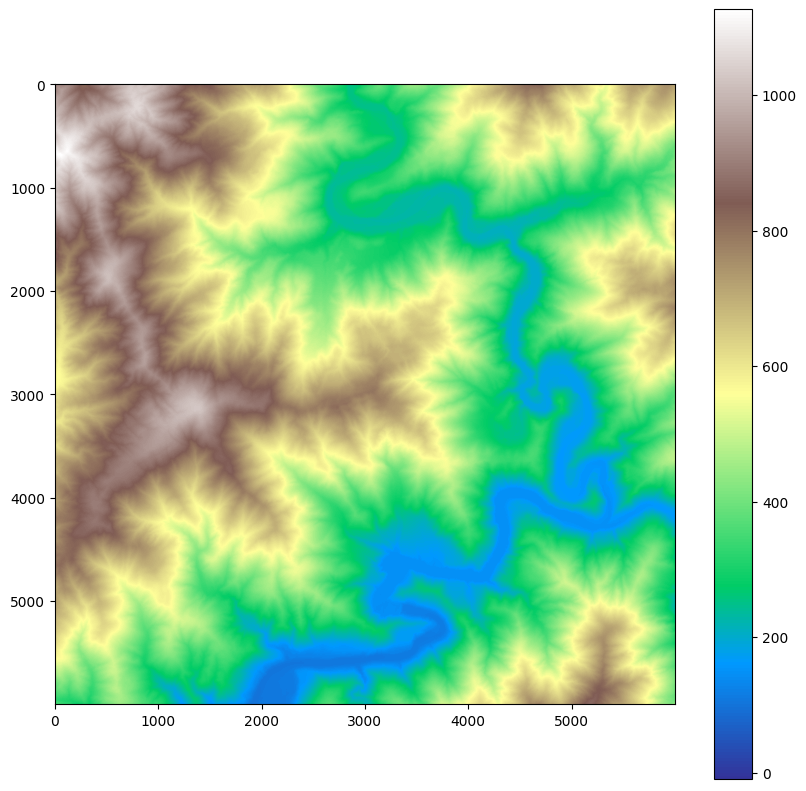

In [ ]:
infiles = glob.glob(base_dir + '*.txt')

dfall = pd.DataFrame()

for i in range(0, len(infiles)):

  df = pd.read_csv(infiles[i],usecols=[1,2,3], header=None, names=('x', 'y', 'z'))

  dfall = pd.concat([dfall, df])
'''
# データがない部分用のダミーデータを作る
d1 = pd.DataFrame()
d2 = pd.DataFrame()
min_x = int(min(dfall['x']))
max_x = int(max(dfall['x']))
min_y = int(min(dfall['y']))
max_y = int(max(dfall['y']))
d1['x'] = list(range(min_x, max_x))
d1['y'] = min_y
d1['z'] = -9999
d2['x'] = min_x
d2['y'] = list(range(min_y, max_y))
d2['z'] = -9999
'''

# ダミーデータを標高の入っているデータフレームに結合する
#dfall = pd.concat([dfall, d1, d2])
# 縦持ちデータを横持ちにピボットする
# データなしと標高値が重なる場合があるので，その場合は最大値（すなわち標高値）を残す
dem = dfall.pivot_table(index = 'y', columns = 'x', values = 'z', fill_value = -9999, aggfunc = 'max')
dem = dem.sort_index(ascending=False)
min_x = dem.columns.min()
max_x = dem.columns.max()
min_y = dem.index.min()
max_y = dem.index.max()
# 横持ちにした標高値を32ビット浮動小数点型のnp.Arrayに変換する
demp = dem.values.astype(np.float32)

# 確認のためDEMを図化する
plt.figure(figsize = (10, 10))
im = plt.imshow(demp, cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()

In [ ]:
# GeoTiff書き出しのためのアフィンパラメータの設定（北西端の座標，メッシュサイズなど）
trans = [min_x, 1, 0, max_y, 0, -1]

# 座標系の設定（EPSG:6672，JGD2000の緯度経度座標系）
srs = osr.SpatialReference()
srs.ImportFromEPSG(6672)

# GeoTiff書き出しのための準備，オブジェクトの生成と初期化
driver = gdal.GetDriverByName('GTiff')
output = driver.Create(base_dir + 'kouchi_dem.tif', 6000, 6000, 1, gdal.GDT_Float32)
output.GetRasterBand(1).WriteArray(demp)
output.GetRasterBand(1).SetNoDataValue(-9999)
output.SetGeoTransform(trans)
output.SetProjection(srs.ExportToWkt())
output.FlushCache()
output = None

In [ ]:
dem = df.pivot_table(index = 'y', columns = 'x', values = 'z', fill_value = -9999)
dem = dem.sort_index()
dem

x,58000.5,58001.5,58002.5,58003.5,58004.5,58005.5,58006.5,58007.5,58008.5,58009.5,...,59990.5,59991.5,59992.5,59993.5,59994.5,59995.5,59996.5,59997.5,59998.5,59999.5
y,,,,,,,,,,,,,,,,,,,,,
60000.5,218.41,218.31,218.22,218.12,218.02,217.98,218.03,217.78,217.49,217.24,...,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
60001.5,218.49,218.39,218.29,218.19,218.09,218.03,218.02,217.72,217.42,216.98,...,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
60002.5,218.48,218.46,218.36,218.27,218.17,218.09,217.96,217.66,217.10,216.52,...,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
60003.5,218.14,218.17,218.20,218.24,218.24,218.15,217.79,217.22,216.65,216.07,...,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
60004.5,217.80,217.83,217.86,217.90,217.93,217.63,217.14,216.54,215.94,215.42,...,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00,-9999.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61495.5,543.35,543.92,544.48,545.05,545.62,546.23,547.08,547.92,548.77,549.61,...,706.14,705.87,705.60,705.34,705.07,704.80,704.54,704.27,704.00,703.74
61496.5,542.28,542.85,543.42,543.98,544.73,545.57,546.42,547.25,548.07,548.88,...,706.70,706.44,706.17,705.90,705.64,705.37,705.11,704.84,704.57,704.31
61497.5,541.22,541.78,542.38,543.22,544.07,544.89,545.71,546.52,547.34,548.16,...,707.27,707.01,706.74,706.47,706.21,705.94,705.67,705.41,705.14,704.87


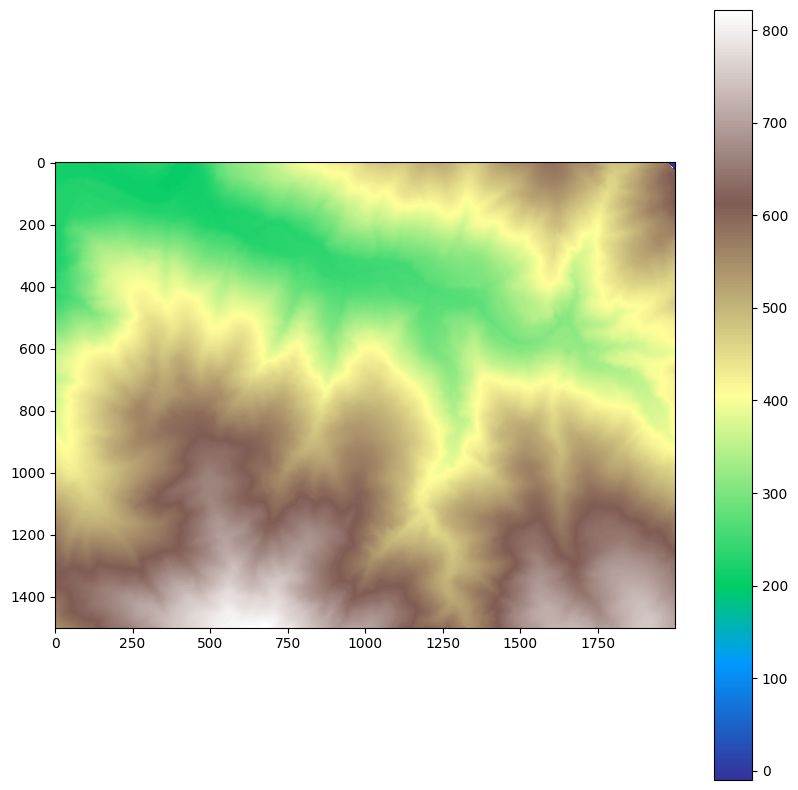

In [ ]:
demp=dem.values.astype(np.float32)
plt.figure(figsize = (10, 10))
im = plt.imshow(demp, cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()

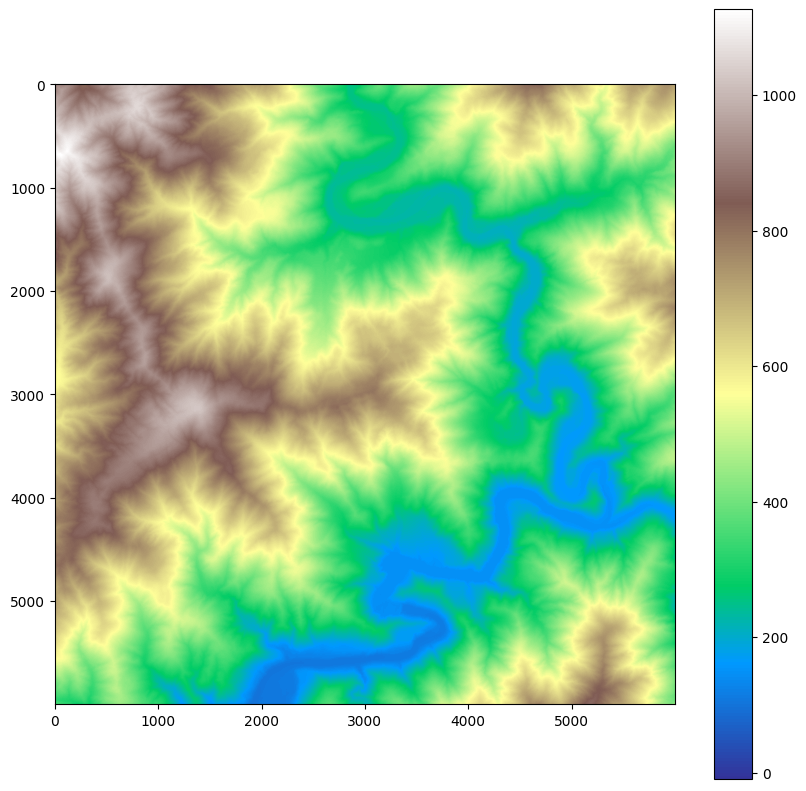

In [ ]:
# 確認のためDEMを図化する
plt.figure(figsize = (10, 10))
im = plt.imshow(dem.sort_index(ascending=False).values.astype(np.float32), cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()

In [ ]:
# GeoTiff書き出しのためのアフィンパラメータの設定（北西端の座標，メッシュサイズなど）
trans = [min_x, 1, 0, max_y, 0, -1]

# 座標系の設定（EPSG:6672，JGD2000の緯度経度座標系）
srs = osr.SpatialReference()
srs.ImportFromEPSG(6672)

# GeoTiff書き出しのための準備，オブジェクトの生成と初期化
driver = gdal.GetDriverByName('GTiff')
output = driver.Create(base_dir + 'kouchi_dem.tif', 6000, 6000, 1, gdal.GDT_Float32)
output.GetRasterBand(1).WriteArray(demp)
output.GetRasterBand(1).SetNoDataValue(-9999)
output.SetGeoTransform(trans)
output.SetProjection(srs.ExportToWkt())
output.FlushCache()
output = None
'''
# DEMをEPSG:6677（JGD2011第9系）に投影変換して保存する
opt = gdal.WarpOptions(dstSRS = 'EPSG:6672', srcNodata = -9999, dstNodata = -9999, outputType=gdal.GDT_Float32, xRes = 1.0, yRes = 1.0, targetAlignedPixels = 'true', resampleAlg = 'bilinear')
demnew = gdal.Warp(base_dir + 'output_dem_reprojected.tif', base_dir + 'output_dem_JGD2011_latlon.tif', options = opt)
demnew.FlushCache()
demnew = None
'''

"\n# DEMをEPSG:6677（JGD2011第9系）に投影変換して保存する\nopt = gdal.WarpOptions(dstSRS = 'EPSG:6672', srcNodata = -9999, dstNodata = -9999, outputType=gdal.GDT_Float32, xRes = 1.0, yRes = 1.0, targetAlignedPixels = 'true', resampleAlg = 'bilinear')\ndemnew = gdal.Warp(base_dir + 'output_dem_reprojected.tif', base_dir + 'output_dem_JGD2011_latlon.tif', options = opt)\ndemnew.FlushCache()\ndemnew = None\n"